In [19]:
import numpy as np
import scipy.integrate as si
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
N = 1001
l = 10
xvec, dx = np.linspace(-l, l, N, retstep=True)
print(dx)
print(dx - (xvec[1] - xvec[0]))

0.02
4.2674197509029455e-16


0.14969001499306073


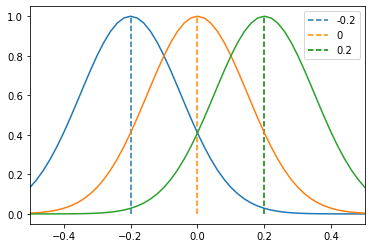

In [21]:
# test of overlap

# define Gaussian basis functions
def gauss(x, j):
    return np.exp(-0.5*((x - j*gx)/sigma)**2)

# set overlap
# this should insure that regardless of how many bases
# we use the overlate will be about the same
# fracmax sets at what fraction of the maximum hight
# we want our basis Gaussians to overlap
fracmax = 0.80
sigma = gx / (2 * np.sqrt(2 * np.log(1/fracmax) ) ) 
print(sigma)

# plot the result
plt.plot(xvec, gauss(xvec,-1))
plt.vlines(-1*gx, ymin=0, ymax=1, label=-1*gx, linestyles='dashed')
plt.plot(xvec, gauss(xvec,0))
plt.vlines(0, ymin=0, ymax=1, label=0, color='darkorange', linestyles='dashed')
plt.plot(xvec, gauss(xvec,1))
plt.vlines(gx, ymin=0, ymax=1, label=gx, color='green', linestyles='dashed')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()

In [22]:
# Let's make it so we can directly
# set the number of Gaussians we use as bases
Ng = 40 # 101

# grid where each point is where one of the Gaussians
# is centered at
xx, gx = np.linspace(-l, l, Ng, retstep=True)
print(xx.shape)
print(xx)

# specify overlap of Gaussians based on some fraction
# their max height
fracmax = 0.80
sigma = gx / (2 * np.sqrt(2 * np.log(1/fracmax) ) ) 

# - we want a SQUARE matrix where each row is one of the
# Gaussian basis functions sampled at the space points
# where the Gaussians basis functions are centered
# - the matrix must be square so we can use numpy.linalg.inv()
# or numpy.linalg.solv()
# - using broadcasting, we only need to expand one of the arrays
# so that np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma)
# ends up with dimensions (Ng, Ng)
gmat = np.exp(-0.5*((xx - np.expand_dims(xx,1))/sigma)**2)
print(gmat.shape)

# this relates to how difficult it will be to invert
# gmat, a bigger number = harder to invert
np.linalg.cond(gmat)

(40,)
[-10.          -9.48717949  -8.97435897  -8.46153846  -7.94871795
  -7.43589744  -6.92307692  -6.41025641  -5.8974359   -5.38461538
  -4.87179487  -4.35897436  -3.84615385  -3.33333333  -2.82051282
  -2.30769231  -1.79487179  -1.28205128  -0.76923077  -0.25641026
   0.25641026   0.76923077   1.28205128   1.79487179   2.30769231
   2.82051282   3.33333333   3.84615385   4.35897436   4.87179487
   5.38461538   5.8974359    6.41025641   6.92307692   7.43589744
   7.94871795   8.46153846   8.97435897   9.48717949  10.        ]
(40, 40)


7.862746607381237

In [23]:
Nfine = N*2
xvecfine, dxfine = np.linspace(-l, l, Nfine, retstep=True)
# gmatplot = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xvec,1))**2 / sigma)
gmatplot = np.exp(-0.5*((xx - np.expand_dims(xvecfine, 1))/sigma)**2)
print(gmatplot.shape)

(2002, 40)


In [24]:
def myfunc(x):
    # out = (x < -3)*(x+3)**3/350 + ((x >= -3) & (x < 6))*(np.exp(-x - 3) - 1) + (x >= 6)*(np.exp(-9) - 1 + (x-6)**2/14)
    out = 2*np.cos(x) + np.sin(5*x)
    # harmonic potential
    # out = 0.5 * x**2
    # double well potential
    # out = 0.5 * (x**2 - 4)**2
    # soft Coulomb
    # out = 1 / np.sqrt(1 + (x - 10)**2)
    return out

In [25]:
# this gives us the coefficents which solve
# gmat @ coefs = myfunc(xx)
coefs = np.linalg.inv(gmat) @ myfunc(xx)
print(coefs.shape)

(40,)


In [26]:
#coefs

0.060550267314970305


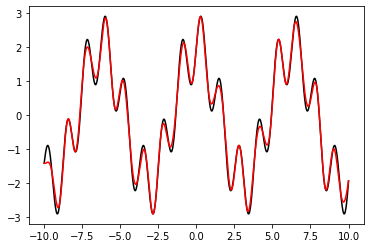

In [27]:
myfuncapprox = gmatplot @ coefs

print(dxfine*np.linalg.norm(myfunc(xvecfine) - myfuncapprox))

plt.plot(xvecfine, myfunc(xvecfine), '-', color='black')

plt.plot(xvecfine, myfuncapprox, '-', color='red')
plt.show()

<h3>Gaussian Basis Transformed to the Fourier Basis</h3>

In [107]:
Nz = 10000
dz = 2 * l / Nz
z = np.expand_dims(-(l+np.arange(Ng)), axis=1) + np.arange(Nz)*dz

kl = np.linspace(-2*np.pi/l, 2*np.pi/l, 4*N - 1)

f1 = np.exp(-1j*np.expand_dims(kl, axis=1)*np.arange(Nz))

f2 = np.exp(-z**2 / (2 * sigma**2))

aprxint = (f2@f1.T)
print(aprxint.shape)



(40, 4003)


In [108]:
from scipy.fft import fft

drctvmat = np.expand_dims(coefs, axis=1)*aprxint

simpvmat = np.sqrt(0.5*np.pi) * (sigma / l) * np.exp(-0.5 * kl**2 * sigma**2) * np.expand_dims(fft(coefs), axis=1)
print(np.linalg.norm(drctvmat - simpvmat))
print(drctvmat - simpvmat)

19484.22460103208
[[0.17333429+3.31983179e-14j 0.17333933+2.19786395e-16j
  0.17334436-2.16091952e-13j ... 0.17334436+2.16091952e-13j
  0.17333933+8.39957429e-13j 0.17333429-3.31983179e-14j]
 [0.18872925+1.56404145e-02j 0.18873473+1.56408690e-02j
  0.18874021+1.56413232e-02j ... 0.18874021+1.56413232e-02j
  0.18873473+1.56408690e-02j 0.18872925+1.56404145e-02j]
 [0.26279916+4.32590200e-02j 0.2628068 +4.32602770e-02j
  0.26281443+4.32615334e-02j ... 0.26281443+4.32615334e-02j
  0.2628068 +4.32602770e-02j 0.26279916+4.32590200e-02j]
 ...
 [0.98376911-2.38799489e-01j 0.9837977 -2.38806428e-01j
  0.98382627-2.38813363e-01j ... 0.98382627-2.38813363e-01j
  0.9837977 -2.38806428e-01j 0.98376911-2.38799489e-01j]
 [0.26279916-4.32590200e-02j 0.2628068 -4.32602770e-02j
  0.26281443-4.32615334e-02j ... 0.26281443-4.32615334e-02j
  0.2628068 -4.32602770e-02j 0.26279916-4.32590200e-02j]
 [0.18872925-1.56404145e-02j 0.18873473-1.56408690e-02j
  0.18874021-1.56413232e-02j ... 0.18874021-1.56413232e-